This notebook contains notes and code taken from the book Build a Large Language Model (From Scratch) written by Sebastian Raschka.

I include notes comming directly from book and information from other sources.

I start my notes from Chapter 2 since the first one has concepts and no code.

# Data loading

Retrieving a text from original github repo.

In [1]:
import urllib.request

url = 'https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt'
file_path = 'the-verdict.txt'
urllib.request.urlretrieve(url, file_path)

('the-verdict.txt', <http.client.HTTPMessage at 0x7b58b28d8700>)

In [2]:
with open(file_path, 'r', encoding='utf-8') as f:
    raw_text = f.read()

print("Total number of character: ", len(raw_text))
print(raw_text[:99])

Total number of character:  20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


# Tokenization

Using `re` library to tokenize the text. The regular expression is based on splitting it by `,`, `.` and whitespace. However, the first 100 characters shown in the previous steps had double dash and, supposing it also contains other special characters like question marks and quotation marks, the regular expression suffer a modification to handle them.

In [3]:
import re

text = "Hello, world. This, is a test."
result = re.split(r"([,.]|\s)", text)
print("Raw tokenization")
print(result)

result = [item for item in result if item.strip()]
print("Tokenization removing whitespaces")
print(result)

Raw tokenization
['Hello', ',', '', ' ', 'world', '.', '', ' ', 'This', ',', '', ' ', 'is', ' ', 'a', ' ', 'test', '.', '']
Tokenization removing whitespaces
['Hello', ',', 'world', '.', 'This', ',', 'is', 'a', 'test', '.']


In [4]:
text = 'Hello, world. Is this--  a test?'
result = re.split(r'([,.:;?_!"()\']|--|\s)', text)
result = [item.strip() for item in result if item.strip()]
print(result)

['Hello', ',', 'world', '.', 'Is', 'this', '--', 'a', 'test', '?']


## Handling the actual text

Once refined the tokenization method, the next step is tokenize the actual text by using the expression previously defined.

At the first block it's easy to see that there are only 4,690 tokens and at the second block the first 31 tokens reveal that the tokenization process works well.

In [5]:
preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text)
preprocessed = [item.strip() for item in preprocessed if item.strip()]
print(len(preprocessed))

4690


In [6]:
print(preprocessed[:30])

['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in']


## Tokens into IDs

This steps converts the text into an integer representation assigning an integer to each token by building a vocabulary. The vocabulary is a map where each unique word and special character to a unique integer.

In [7]:
all_words = sorted(set(preprocessed))
vocab_size = len(all_words)
print(vocab_size)

1130


In [8]:
vocab = {token: integer for integer, token in enumerate(all_words)}
for i, item in enumerate(vocab.items()):
    print(item)
    if i >= 50:
        break

('!', 0)
('"', 1)
("'", 2)
('(', 3)
(')', 4)
(',', 5)
('--', 6)
('.', 7)
(':', 8)
(';', 9)
('?', 10)
('A', 11)
('Ah', 12)
('Among', 13)
('And', 14)
('Are', 15)
('Arrt', 16)
('As', 17)
('At', 18)
('Be', 19)
('Begin', 20)
('Burlington', 21)
('But', 22)
('By', 23)
('Carlo', 24)
('Chicago', 25)
('Claude', 26)
('Come', 27)
('Croft', 28)
('Destroyed', 29)
('Devonshire', 30)
('Don', 31)
('Dubarry', 32)
('Emperors', 33)
('Florence', 34)
('For', 35)
('Gallery', 36)
('Gideon', 37)
('Gisburn', 38)
('Gisburns', 39)
('Grafton', 40)
('Greek', 41)
('Grindle', 42)
('Grindles', 43)
('HAD', 44)
('Had', 45)
('Hang', 46)
('Has', 47)
('He', 48)
('Her', 49)
('Hermia', 50)


## Tokenizer

To tokenizer in a simplier form, it's create a `SimpleTokenizerV1` class. It takes a vocabulary and create an inverse one to correctly maps the IDs into tokens.

The motivation behind it is that once the LLM is trained with the IDs, the model will return integer IDs, not text. To interpretate the LLM resuls the class implements a decode method that will map the IDs into strings.

>Note: The tokenizer works well on known words (i.e. words inside the vocabulary). If a new word is presetend to the tokenizer, it will produce an error since there new word has no ID associated.

In [9]:
class SimpleTokenizerV1:

    def __init__(self, vocab):
        # stores the vocabulary
        self.str_to_int = vocab
        # Inverse vocabulary that maps token IDs back to the original text tokens
        self.int_to_str = {i:s for s,i in vocab.items()}

    def encode(self, text):
        # Processes input text into token IDs
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids

    def decode(self, ids):
        # Converts token IDs back into text
        text = " ".join([self.int_to_str[i] for i in ids])
        # Removes spaces before the specified punctuation
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text

In [10]:
tokenizer = SimpleTokenizerV1(vocab)
text = """
It's the last he painted, you know, " Mrs. Gisburn said with pardonable pride.
"""
ids = tokenizer.encode(text)
print(ids)

[56, 2, 850, 988, 602, 533, 746, 5, 1126, 596, 5, 1, 67, 7, 38, 851, 1108, 754, 793, 7]


In [11]:
print(tokenizer.decode(ids))

It' s the last he painted, you know," Mrs. Gisburn said with pardonable pride.


## Context tokens

To improve the `SimpleTokenizerV1` it's time to introduce two new context tokens.

1. `<|unk|>` this will be used when words that where not part of the training are introduced to the tokenizer.
2. `<|endoftext|>` token that will be used to separate two unrelated text sources.

As mentioned, the first one will be useful to represent unseen words. While the second one will help the LLM to understand that in fact multiple text sources are concatenated for training, they are unrelated.

In [12]:
all_tokens = sorted(list(set(preprocessed)))
all_tokens.extend(["<|endoftext|>","<|unk|>"])
vocab = {token: integer for integer,token in enumerate(all_tokens)}

print(len(vocab.items()))

1132


In [13]:
for i, item in enumerate(list(vocab.items())[-5:]):
    print(item)

('younger', 1127)
('your', 1128)
('yourself', 1129)
('<|endoftext|>', 1130)
('<|unk|>', 1131)


In [14]:
class SimpleTokenizerV2:

    def __init__(self, vocab):
        # stores the vocabulary
        self.str_to_int = vocab
        # Inverse vocabulary that maps token IDs back to the original text tokens
        self.int_to_str = {i:s for s,i in vocab.items()}

    def encode(self, text):
        # Processes input text into token IDs
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        # Replaces unkown words by <|unk|> tokens
        preprocessed = [item if item in self.str_to_int else "<|unk|>" for item in preprocessed]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids

    def decode(self, ids):
        # Converts token IDs back into text
        text = " ".join([self.int_to_str[i] for i in ids])
        # Removes spaces before the specified punctuation
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text

In [15]:
# In this example, Hello and palace are not part of the training dataset, therefore the tokenizer assign them the <|unk|> token

text1 = "Hello, do you like tea?"
text2 = "In the sunlit terraces of the palace."
text = "<|endoftext|> ".join((text1, text2))
print(text)

Hello, do you like tea?<|endoftext|> In the sunlit terraces of the palace.


In [16]:
tokenizer = SimpleTokenizerV2(vocab)
print(tokenizer.encode(text))

[1131, 5, 355, 1126, 628, 975, 10, 1130, 55, 988, 956, 984, 722, 988, 1131, 7]


In [17]:
print(tokenizer.decode(tokenizer.encode(text)))

<|unk|>, do you like tea? <|endoftext|> In the sunlit terraces of the <|unk|>.


## Byte Pairing Encoding (BPE)

BPE is a tokenizer that has several properties that outperforms classic tokenizers:

1. It is reversible
2. It works on arbitrary text
3. It compress the text
4. It attempts to let the model see common subwords

The algorithm breaks down words that aren't in its predefined vocabulary into smaller subword units or even individual characters, enabling it to handle out-of-vocabulary words.

In [18]:
import tiktoken

tokenizer = tiktoken.get_encoding('gpt2')

In [19]:
text = "Hello, do you like tea? <|endoftext|> In the sunlit terraces of someunkownPlace."

integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
print(integers)

[15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 286, 617, 2954, 593, 27271, 13]


In [20]:
string = tokenizer.decode(integers)
print(string)

Hello, do you like tea? <|endoftext|> In the sunlit terraces of someunkownPlace.


### Exercise 2.1 Byte pair encoding of unkown words

Trying BPE tokenizer from the tiktoken. I will call the encode method on the unknown words `Akwirw ier` and decode them one by one and all at once to see if the algorithm is capable of reconstruct the original input.

> Result: As mentioned before, the BPE algorithm encode the words depending on how many times a set of letters or words have been repeted in the text. This provice the algorithm information about the relevance and connectedness of letters or words inside a text. Providing it with capabilities like encoding unkown words.

In [21]:
# Encoding the unkown word
unk_word_int = tokenizer.encode('Akwirw ier')
print(unk_word_int)

[33901, 86, 343, 86, 220, 959]


In [22]:
# Then, decode it one ID at a time
for word_int in unk_word_int:
    print(tokenizer.decode([word_int]))

Ak
w
ir
w
 
ier


In [23]:
# Decode them all at once
tokenizer.decode(unk_word_int)

'Akwirw ier'

## Data sampling with a sliding window

Preparing the data for the first task that is word prediction, it's necessary to create some functionality that can split the data as the text goes on.

For example, if the text is `and established himself in`, then the preparation data to train a next word prediction should be something like this:

`and ----> established`
`and established ----> himself`
`and established himself in ---> a`

This text preparation is calles shifting, and the next cells will show how to do this.

In [24]:
# First, encoding the original text using tiktoken
enc_text = tokenizer.encode(raw_text)
print(len(enc_text))

5145


In [25]:
# Then, removing the first 50 tokens
enc_sample = enc_text[50:]

In [26]:
# Now, using a context size (a sampling window), a representation of value and prediction is shown
# (shifting the original text 1 space to the right)
context_size = 4
x = enc_sample[:context_size]
y = enc_sample[1:context_size + 1]
print(f"x: {x}")
print(f"y:      {y}")

x: [290, 4920, 2241, 287]
y:      [4920, 2241, 287, 257]


In [27]:
# Then, combine the idea into a loop so the sample is shifted
# Here, the tokens after the arrow (--->) represents the desired output
# While the tokens before it, represents the input.
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]
    print(context, "---->", desired)

[290] ----> 4920
[290, 4920] ----> 2241
[290, 4920, 2241] ----> 287
[290, 4920, 2241, 287] ----> 257


In [28]:
# This last step is using the decoded tokens
for i in range(1, context_size + 1):
    context = enc_sample[:i]
    desired = enc_sample[i]
    print(tokenizer.decode(context), "---->", tokenizer.decode([desired]))

 and ---->  established
 and established ---->  himself
 and established himself ---->  in
 and established himself in ---->  a


## Data loader

Now that the logic is clear, here a Data loader is created. This class purpose is to shift the original text by 1 position while representing it as a tensor.

After the class, there is a function that uses the data loader to generate batches with input-with pairs.

In [29]:
import torch
from torch.utils.data import Dataset, DataLoader
class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenizes the entire text
        token_ids = tokenizer.encode(txt)
        for i in range(0, len(token_ids) - max_length, stride):
            # Uses a sliding window to chunk the book into overlapping sequences of max_length
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length]

            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        # Returns the total number of rows in the dataset
        return len(self.input_ids)

    def __getitem__(self, idx):
        # Returns a single row from the dataset
        return self.input_ids[idx], self.target_ids[idx]

In [30]:
def create_dataloader_v1(txt, batch_size=4, max_length=256, 
                         stride=128, shuffle=True, drop_last=True, num_workers=0):
    # Initializes the tokenizer
    tokenizerr = tiktoken.get_encoding("gpt2")
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)
    # Creates dataset
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        # drops the last batch if it is shorter than the specified batch_size to prevent 
        # loss spikes during training
        drop_last=drop_last,
        # The number of CPU processes to use for preprocessing
        num_workers=num_workers
    )
    return dataloader

In [31]:
dataloader = create_dataloader_v1(raw_text, batch_size=1, max_length=4, stride=1, shuffle=False)
data_iter = iter(dataloader)
first_batch = next(data_iter)
print(first_batch)

[tensor([[  40,  367, 2885, 1464]]), tensor([[ 367, 2885, 1464]])]


In [32]:
second_batch = next(data_iter)
print(second_batch)

[tensor([[ 367, 2885, 1464, 1807]]), tensor([[2885, 1464, 1807]])]


### Exercise 2.2 Data loaders with different strides and context sizes

What the data loader does is splitting the text into batches (to be further used on the deeplearning model) using a `max_length` as the number of tokens in the context and the `stride` is the number of position the windows is going to be moved to the rigth.

In other words:

- `max_length` creates a representation of the numbers of tokens used to the context
- `stride` the window size that the algorithm is going to move to the next batch

In [33]:
# Here the max_length of two shows that the context only contains two previous tokens to predict
# the outcome.
# While the stride shows that the window is moving two spaces away from the first word
dataloader = create_dataloader_v1(raw_text, batch_size=1, max_length=2, stride=2, shuffle=False)
data_iter = iter(dataloader)
first_batch = next(data_iter)
print(first_batch)

[tensor([[ 40, 367]]), tensor([[367]])]


In [34]:
# On this example, the context contains 8 tokens to predict the outcome
# while the stride only moves to spaces. Here the stride context is clearer since the outcome contains
# the second token away from the begining (367).
dataloader = create_dataloader_v1(raw_text, batch_size=1, max_length=8, stride=2, shuffle=False)
data_iter = iter(dataloader)
first_batch = next(data_iter)
print(first_batch)

[tensor([[  40,  367, 2885, 1464, 1807, 3619,  402,  271]]), tensor([[ 367, 2885, 1464, 1807, 3619,  402,  271]])]


In [35]:
# The amount of data to train a deep learning model requires lot more of data, that why here 
# the batch_size is 8 to create a tensor of 8x4 size (batch_size x max_length)
# And stride of 4. Having a max_length and stride the same size avoid overlapping between batches
# since more overlap could lead to increased overfitting.
dataloader = create_dataloader_v1(raw_text, batch_size=8, max_length=4, stride=4, shuffle=False)

data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Inputs:\n", inputs)
print("\nTargets:\n", targets)

Inputs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Targets:
 tensor([[ 367, 2885, 1464],
        [3619,  402,  271],
        [2138,  257, 7026],
        [ 438, 2016,  257],
        [5891, 1576,  438],
        [ 340,  373,  645],
        [5975,  284,  502],
        [3285,  326,   11]])


## Token embedings

Until this step, all did was to create a numeric represetation of the original text, but they are not embeddings vectors. The embeddings vectors are context representation of words in a high dimensional vector space, each vector can be operated using other vectors.

Vectors that are related to each other will have a smaller distance and angle. While their opposites will have higher angle. Moreover, words that are not related to each other will have higher distances relative to others.

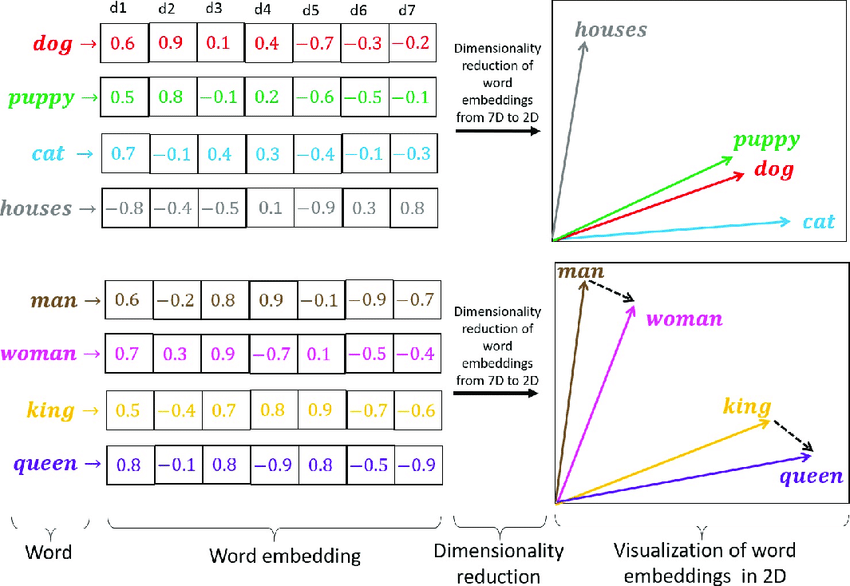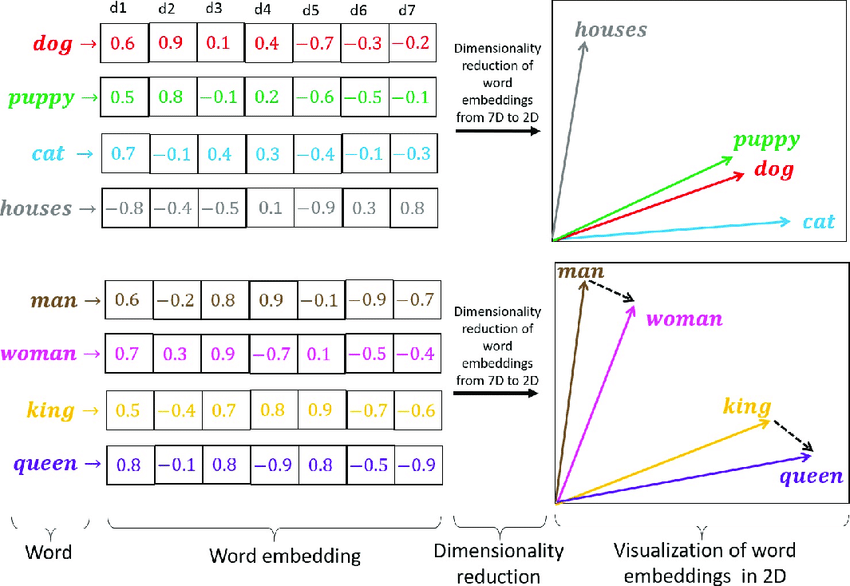

As a preliminary step for the embedding model, it is required to initialize the embedding weights with random values (this is called warmup) so it doesn't start cold (warming up the model help to find a solution faster and avoid valleys where the model could stuck).

Using `torch` `Embedding` layer is a fancy representation of one-hot encoder and matrix multiplication in a fully connected layer (that is, having a high dimensional one-hot and doing a dimensionality reduction using matrix multiplication). Said this, the way to optimize this layer is by training it using backpropagation (as one optimizes the no-negative matrix decomposition).

>NOTE: For more conceptual understanding on how embeddings works, here is a [video](https://youtu.be/wjZofJX0v4M?t=747&si=PYii_yDpiTVC89ji) that explain it better

In [36]:
input_ids = torch.tensor([2, 3, 5, 1])
vocab_size = 6
output_dim = 3

torch.manual_seed(123)
embedding_layer = torch.nn.Embedding(vocab_size, output_dim)
print(embedding_layer.weight)

Parameter containing:
tensor([[ 0.3374, -0.1778, -0.1690],
        [ 0.9178,  1.5810,  1.3010],
        [ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096]], requires_grad=True)


In [37]:
# This is basically a lookup operations, the number 3 here corresponds to the fourth 
# row in the embedding_layer.weights
print(embedding_layer(torch.tensor([3])))

tensor([[-0.4015,  0.9666, -1.1481]], grad_fn=<EmbeddingBackward0>)


In [38]:
# Using the input_ids defined above
print(embedding_layer(input_ids))

tensor([[ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-2.8400, -0.7849, -1.4096],
        [ 0.9178,  1.5810,  1.3010]], grad_fn=<EmbeddingBackward0>)


## Encoding word positions

LLMs doesn't have a notion of position or order for the tokens within a sequence because of their self-attention mechanism. This means no matter how the embedding layer represent the tokens, the LLM will only consider their vector representation and similarity.

The deterministic position-independent embedding of the token ID is good for reproducibility. Since the self-attention mechanism of the LLM is position-agnostic, it is helpful to inject additional position information into the LLM.

In [39]:
vocab_size = 50_257
output_dim = 256
token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

max_length = 4
dataloader = create_dataloader_v1(raw_text, batch_size=8, max_length=max_length, 
                                  stride=max_length, shuffle=False)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Token IDs:\n", inputs)
print("\nInputs shape:\n", inputs.shape)

Token IDs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Inputs shape:
 torch.Size([8, 4])


In [40]:
token_embeddings = token_embedding_layer(inputs)
print(token_embeddings.shape)

torch.Size([8, 4, 256])


In [41]:
context_length = max_length
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)
# This will create a placeholder having an array with consecutive numbers.
pos_embeddings = pos_embedding_layer(torch.arange(context_length))
print(pos_embeddings.shape)

torch.Size([4, 256])


In [42]:
# At this step, the input embeddings is the sum of the token embeddings 
# (generated by the embedding layer) and a positional embeddings 
# (that represent the order of each embedding)
input_embeddings = token_embeddings + pos_embeddings
print(input_embeddings.shape)

torch.Size([8, 4, 256])


# Self-attention mechanism

The next step is to create an attention mechanism that provides to the LLM relevant context to each word.

For example, having the phrases:

- American shrew mole
- One mole of carbon dioxide
- Take a biopsy of the mole

In these three phrases **mole** mean different things, but the LLM doesn't know what you refer to since their tokens are exactly the same.

Therefore, the LLM should be capable of extracting the context to each sentence and build the meaning of each **mole** based on their surrounding context.

Before transformers where popular, Recurrent Neural Networks (RNNs) were the way to perform translations becuase of their capability to extract information from sequence, using a similar architecture of encoder-decoder. However, their predictions relies only in the very next word, without considering previous words.

Researchers developed the Bahdanau attention mechanism for RNNs in 2014, allowing the decoder ti sekectuveky access dufferent parts of the input sequence at each decoding step.

This motivates other researches to create self-attention mechanisms without the usage of deep neural networks.

> NOTE: This [video](https://youtu.be/eMlx5fFNoYc?si=SJOY9jKveNWiMTfb) explaing better than I how attention mechanism works.

## Attending to different parts of the input with self-attention

The **"self"** refers to the mechanism's ability to compute attention weights by relating different positions within a single input sequence (like said before, the LLM should build the meaning of all words in a sentence).

In the following example, the intention is to achieve the following:

1. Compute attention scores
2. Compute attention weights (or `w`)
3. Compute context vector

> **What is query, key and value?**
> 
> The concept is borrowed from infromation retrieval and databases.
>
> Where ***query*** is the search term, represented here as the current item;
> 
> ***key*** is used for indexing and searching, in attention mechanisms each word in a sentence has an associated key; and
>
> ***value*** is similar to the value in a key-value pair in a database, represented as the actual content or presentation of the input items.

In [43]:
import torch
inputs = torch.tensor(
    [[0.43, 0.15, 0.89], # Your
     [0.55, 0.87, 0.66], # journey
     [0.57, 0.85, 0.64], # starts
     [0.22, 0.58, 0.33], # with
     [0.77, 0.25, 0.10], # one
     [0.05, 0.80, 0.55]] # step
)

In [44]:
# 1. Attention scores

# To calculate attention scores between the query token and each input token, we use the dot product
query = inputs[1]
attn_scores_2 = torch.empty(inputs.shape[0])
for i, x_i in enumerate(inputs):
    attn_scores_2[i] = torch.dot(x_i, query)

print(attn_scores_2)

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


In [45]:
# 2. Attention weights

# Now, lets convert the scores into weights by normalizing them.

# Normalization will make all scores to sum up to 1, 
# this is a common practice that's useful for interpretation and training stability.

# Using softmax manage extreme values and offers more favorable gradient properties during training.

# In addition, softmax ensures that all values are positive, 
# making the output interpretable as probabilities

attn_weights_2 = torch.softmax(attn_scores_2, dim=0)
print("Attention weights: ", attn_weights_2)

Attention weights:  tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])


In [46]:
# 3. Context Vector

# Last step is calculate the context vector. This vector is a weighted sum of all input vectors.

query = inputs[i]
context_vec_2 = torch.zeros(query.shape)
for i, x_i in enumerate(inputs):
    context_vec_2 += attn_weights_2[i]*x_i

print(context_vec_2)

tensor([0.4419, 0.6515, 0.5683])


In [47]:
# Generalizing the previous three steps into a single one to compute context vectors to all inputs

# 1. Attention scores
attn_scores = inputs @ inputs.T # <- the @ is the same as having two for loops 
                                #    multiplying the two dimension input.

print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


In [48]:
# 2. Attention weights

attn_weights = torch.softmax(attn_scores, dim=-1)
print(attn_weights)

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])


In [49]:
# 3. Context vectors

all_context_vecs = attn_weights @ inputs
print(all_context_vecs)

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])


## Self-attention mechanism with trainable weights

The next step is adding trainable weights that are updated during model training, so the model can learn to produce good context vectors.

The new self-attention mechanism will use three trainable weights matrices, $W_q$, $W_k$, $W_v$. These matrices are used to project the embedded input tokens into query, key, and value vectors.

The first word would only has key and value vectors, then the second word would has query, key and value vectors (the query vector is computed via matrix multiplication between the input and the weight matrix $W_q$).

In [50]:
x_2 = inputs[1]
d_in = inputs.shape[1]
d_out = 2

torch.manual_seed(123)
W_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_key = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_value = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)

In [51]:
# Query, key and values computation

query_2 = x_2 @ W_query
key_2 = x_2 @ W_key
value_2 = x_2 @ W_value

print(query_2)

tensor([0.4306, 1.4551])


In [52]:
# Keys and values vectors

keys = inputs @ W_key
values = inputs @ W_value
print("keys.shape: ", keys.shape)
print("values.shape: ", values.shape)

keys.shape:  torch.Size([6, 2])
values.shape:  torch.Size([6, 2])


In [53]:
# Attention scores

keys_2 = keys[1]
attn_scores_22 = query_2.dot(keys_2)
print(attn_scores_22)

tensor(1.8524)


In [54]:
# Attention scores generalization

attn_scores_2 = query_2 @ keys.T
print(attn_scores_2)

tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440])


In [55]:
# Attention scores normalization (attention weights)
# At this step, a scaling is performed over the attention scores. This is to avoid small gradients that
# can turn softmax function into a step function, slowing down learning.

d_k = keys.shape[-1]
attn_weights_2 = torch.softmax(attn_scores_2 / d_k**0.5, dim=-1)
print(attn_weights_2)

tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820])


In [56]:
context_vec_2 = attn_weights_2 @ values
print(context_vec_2)

tensor([0.3061, 0.8210])


In [57]:
# Compact self-attention class
import torch.nn as nn

class SelfAttention_v1(nn.Module):

    def __init__(self, d_in, d_out):
        super().__init__()
        self.W_query = nn.Parameter(torch.rand(d_in, d_out))
        self.W_key = nn.Parameter(torch.rand(d_in, d_out))
        self.W_value = nn.Parameter(torch.rand(d_in, d_out))

    def forward(self, x):
        keys = x @ self.W_key
        queries = x @ self.W_query
        values = x @ self.W_value
        attn_scores = queries @ keys.T # omega
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )
        context_vec = attn_weights @ values
        return context_vec

In [58]:
torch.manual_seed(123)
sa_v1 = SelfAttention_v1(d_in, d_out)
print(sa_v1(inputs))

tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]], grad_fn=<MmBackward0>)


In [59]:
# To improve performance and be able to optimice weights, we replace nn.Parameter to nn.Linear
# This layer calculates dot product if bias is removed

class SelfAttention_v2(nn.Module):

    def __init__(self, d_in, d_out, qkv_bias=False):
        super().__init__()
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

    def forward(self, x):
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)
        attn_scores = queries @ keys.T # omega
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )
        context_vec = attn_weights @ values
        return context_vec

In [60]:
torch.manual_seed(123)
sa_v2 = SelfAttention_v2(d_in, d_out)
print(sa_v2(inputs))

tensor([[-0.5337, -0.1051],
        [-0.5323, -0.1080],
        [-0.5323, -0.1079],
        [-0.5297, -0.1076],
        [-0.5311, -0.1066],
        [-0.5299, -0.1081]], grad_fn=<MmBackward0>)


In [61]:
# The author suggests to validate whether two methods are numerically correct. Therefore, produce
# the same result, since the SelfAttention_v2 uses a linear layer and the SeflAttention_v1 builds
# the weights manually, then we should transfer the weights from one to another.

# Entering into details, the way to do that is by extracting the weights from each Linear layer and 
# transpose them to then make a copy into an instance of SelfAttention_v1.

# By doing this, we can confirm that the output is the same, so the processes are numerically correct.

with torch.no_grad(): # <- nn.Layer uses gradiant, to copy weights we need to tell torch not to copy the grads
    sa_v1.W_query.copy_(sa_v2.W_query.weight.T.data)
    sa_v1.W_value.copy_(sa_v2.W_value.weight.T.data)
    sa_v1.W_key.copy_(sa_v2.W_key.weight.T.data)

print(sa_v1(inputs))

tensor([[-0.5337, -0.1051],
        [-0.5323, -0.1080],
        [-0.5323, -0.1079],
        [-0.5297, -0.1076],
        [-0.5311, -0.1066],
        [-0.5299, -0.1081]], grad_fn=<MmBackward0>)


## Causal attention

When training LLM, the desired outcome will require to consider only token that appear prior to the current position.

Causal attention is also know as *masked attention*, it restricts a model to only consider previous and current inputs in a sequence when processing any given token when computing attention socres.

The idea is to mask the attention weights above the diagonal and normalize the nonmasked attention weights such that the attention weights sum to 1 in each row.

In [62]:
# Reusing the SelfAttention mechanism v2, calculate the attention scores of the input
queries = sa_v2.W_query(inputs)
keys = sa_v2.W_key(inputs)
attn_scores = queries @ keys.T
attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
print(attn_weights)

tensor([[0.1717, 0.1762, 0.1761, 0.1555, 0.1627, 0.1579],
        [0.1636, 0.1749, 0.1746, 0.1612, 0.1605, 0.1652],
        [0.1637, 0.1749, 0.1746, 0.1611, 0.1606, 0.1651],
        [0.1636, 0.1704, 0.1702, 0.1652, 0.1632, 0.1674],
        [0.1667, 0.1722, 0.1721, 0.1618, 0.1633, 0.1639],
        [0.1624, 0.1709, 0.1706, 0.1654, 0.1625, 0.1682]],
       grad_fn=<SoftmaxBackward0>)


In [63]:
# Then create the hidding mask
context_length = attn_scores.shape[0]
mask_simple = torch.tril(torch.ones(context_length, context_length))
print(mask_simple)

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])


In [64]:
# Apply the hidding mask to the actual attention weights to hide the weights above the diagonal
masked_simple = attn_weights*mask_simple
print(masked_simple)

tensor([[0.1717, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1636, 0.1749, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1637, 0.1749, 0.1746, 0.0000, 0.0000, 0.0000],
        [0.1636, 0.1704, 0.1702, 0.1652, 0.0000, 0.0000],
        [0.1667, 0.1722, 0.1721, 0.1618, 0.1633, 0.0000],
        [0.1624, 0.1709, 0.1706, 0.1654, 0.1625, 0.1682]],
       grad_fn=<MulBackward0>)


In [65]:
# Renormalize the attention weights to sum up to 1
row_sums = masked_simple.sum(dim=-1, keepdim=True)
masked_simple_norm = masked_simple / row_sums
print(masked_simple_norm)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4833, 0.5167, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3190, 0.3408, 0.3402, 0.0000, 0.0000, 0.0000],
        [0.2445, 0.2545, 0.2542, 0.2468, 0.0000, 0.0000],
        [0.1994, 0.2060, 0.2058, 0.1935, 0.1953, 0.0000],
        [0.1624, 0.1709, 0.1706, 0.1654, 0.1625, 0.1682]],
       grad_fn=<DivBackward0>)


> #### Information leakage
>
> It might appear that the information for future tokens (the ones that are hidden) could still influence the current token becuase their values are part of the softmax calculation.
>
> However, when renormalizing the attention weights after masking, weights are recalculated by softmax. The above diagonal doesn't contribute to the softmax score becuase its values are nullified.
>
> Masking and renormalizing the distribution of the attention weights is as if it was calculated only among the unmasked position to begin with.

An efficient way to obtain the masked attention weight matrix, and the one that will be implemented in the next cells, is as follow:

1. Attention scores (unnormalized)
   - Mask with $-\infty$ above diagonal
2. Masked attention scores (unnormalized)
   - Apply softmax
3. Masked attention weights (normalized)

#### Why using $-\infty$ to mask instead of zero?

Before answer the question, let's review the softmax formula

$$
softmax(z_i) = \frac{e^{z_i}}{\sum_je^{z_j}}
$$

When $z_j=0$ then $e^{z_j}=1$ becuase any number powered to zero will be 1. Therefore, all masked values by 0 will contribute to the softmax socre, to avoid any contribution by the above diagonal (i.e. the masked values) $z_j$ must be $-\infty$.

To prove that, we can plot $e^x$ where $x \in [-3,3]$, being visible that $e$ decrease, tending to zero (also, if you calculate $\lim_{x \to -\infty}e^x$ you will get that $e^x=0$. Meaning that all values masked with $-\infty$ will not contribute to the softmax score.

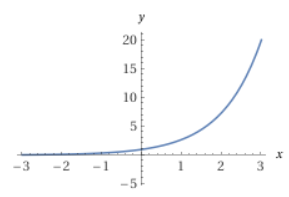

In [66]:
mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
masked = attn_scores.masked_fill(mask.bool(), -torch.inf)
print(masked)

tensor([[0.3111,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.1655, 0.2602,   -inf,   -inf,   -inf,   -inf],
        [0.1667, 0.2602, 0.2577,   -inf,   -inf,   -inf],
        [0.0510, 0.1080, 0.1064, 0.0643,   -inf,   -inf],
        [0.1415, 0.1875, 0.1863, 0.0987, 0.1121,   -inf],
        [0.0476, 0.1192, 0.1171, 0.0731, 0.0477, 0.0966]],
       grad_fn=<MaskedFillBackward0>)


In [67]:
# The output values sum to 1 in each row
attn_weights = torch.softmax(masked / keys.shape[-1]**0.5, dim=1)
print(attn_weights)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4833, 0.5167, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3190, 0.3408, 0.3402, 0.0000, 0.0000, 0.0000],
        [0.2445, 0.2545, 0.2542, 0.2468, 0.0000, 0.0000],
        [0.1994, 0.2060, 0.2058, 0.1935, 0.1953, 0.0000],
        [0.1624, 0.1709, 0.1706, 0.1654, 0.1625, 0.1682]],
       grad_fn=<SoftmaxBackward0>)


## Dropout

During the LLM training it's necessary to use a deep learning technique called dropout, it consists on randomly selecting hiddel layer units and ignored them.

This method helps prevent overfitting by ensuring that a model does not become overly reliant on any specific set of hidden layer units.

This technique is used **ONLY** during training and is disabled afterward.

The dropout can ocurr either after calculating the attention weights or after applying the attention weights to the value vectors. In this example, the dropout will take place after computing the attention weights.

The dropout rate is goint to be of 50%, but when training the real model, the dropout rate will lower to 0.1 or 0.2.

When applying dropout with a rate of 50%, half of the elements in the matrix are randomly set to zero. To compensate for the reduction, active elements scaled up their values by a factor of $1/0.5 = 2$. This scaling is crucial to maintain the overall balance of the attention weights.

In [68]:
torch.manual_seed(123)
dropout = torch.nn.Dropout(0.5)
example = torch.ones(6, 6)
print(dropout(example))

tensor([[2., 2., 2., 2., 2., 2.],
        [0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 2., 0.],
        [2., 2., 0., 0., 0., 2.],
        [2., 0., 0., 0., 0., 2.],
        [0., 2., 0., 0., 0., 0.]])


In [69]:
torch.manual_seed(123)
print(dropout(attn_weights))

tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0335, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.6804, 0.0000, 0.0000, 0.0000],
        [0.4889, 0.5090, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3988, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3418, 0.0000, 0.0000, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)


In [70]:
# Causal attention mechanism implementation
class CausalAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, qkv_bias=False):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        
        self.dropout = nn.Dropout(dropout) # Adding dropout layer
        self.register_buffer(
            'mask',
            torch.triu(torch.ones(context_length, context_length), diagonal=1)
        ) # Ensures this tensor is allocated in the same device as the rest of the LLM

    def forward(self, x):
        b, num_tokens, d_in = x.shape # Keeps batch dimension at the first position (0)
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        attn_scores = queries @ keys.transpose(1,2)
        # The masked_fill operation occurrs in memory
        # this happens to all operations with an underscore
        attn_scores.masked_fill_(self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context_vec = attn_weights @ values
        return context_vec

In [71]:
batch = torch.stack((inputs, inputs), dim=0)
print(batch.shape)

torch.Size([2, 6, 3])


In [72]:
torch.manual_seed(123)
context_length = batch.shape[1]
ca = CausalAttention(d_in, d_out, context_length, 0.0)
context_vecs = ca(batch)
print("context_vecs.shape:", context_vecs.shape)

context_vecs.shape: torch.Size([2, 6, 2])


## Multi-head attention

The final step for attention mechanisms is to extend the causal attention class over multiple heads. This is called *multi-head attention*.

The term *"multi-head"* refers to dividing the attention mechanism into multiple *"heads"*, each operating independently.

To tackle this expansing, the first steps is intuitively build a multi-head attention module by stacking multiple CausalAttention modules.

The wrapper consists on having multiple instance of the CausalAttention class and then combine their outputs.

However, the `MultiHeadAttentionWrapper` works sequentially becuase of the `for` loop, also being computational inneficient. One way to be more efficient is by computing the output for all attention heads simultaneously via matrix multiplication.

In [73]:
class MultiHeadAttentionWrapper(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        self.heads = nn.ModuleList(
            [CausalAttention(
                d_in, d_out, context_length, dropout, qkv_bias
             ) 
             for _ in range(num_heads)]
        )

    def forward(self, x):
        return torch.cat([head(x) for head in self.heads], dim=-1)

In [74]:
torch.manual_seed(123)
context_length = batch.shape[1] # Number of tokens
d_in, d_out = 3, 2
mha = MultiHeadAttentionWrapper(
    d_in, d_out, context_length, 0.0, num_heads=2
)
context_vecs = mha(batch)

print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]],

        [[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]]], grad_fn=<CatBackward0>)
context_vecs.shape: torch.Size([2, 6, 4])


In [75]:
# The author suggets the following exercise. Changing the input arguments for the 
# MultiHeadAttentionWrapper, so the output context vectos are two-dimensional instead 
# of four dimensional

# To achieve the desire result, I change the d_out variable since the last dimension (2) is the result
# of multiplying d_out by num_heads.

# Said this, one can get the same result by modifying num_heads to 1

torch.manual_seed(123)
context_length = batch.shape[1] # Number of tokens
d_in, d_out = 3, 1
mha = MultiHeadAttentionWrapper(
    d_in, d_out, context_length, 0.0, num_heads=2
)
context_vecs = mha(batch)

print("context_vecs.shape:", context_vecs.shape)

context_vecs.shape: torch.Size([2, 6, 2])


In [76]:
# Causal attention mechanism implementation based on matrix multiplication

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), "d_out must be divisible by num_heads"
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduces projection dim to match the desired output dim
        
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        
        self.out_proj = nn.Linear(d_out, d_out) # Used to combine heads output
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            'mask',
            torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        
        keys = self.W_key(x) # Tensor shape (b, num_tokens, d_out)
        queries = self.W_query(x) # Tensor shape (b, num_tokens, d_out)
        values = self.W_value(x) # Tensor shape (b, num_tokens, d_out)

        # Implicitly split the matrix by adding a num_head dimension
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose from shape (b, num_tokens, num_heads, head_dim) to
        # (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        attn_scores = queries @ keys.transpose(2, 3) # Dot product for each head
        # Mask truncated to the number of tokens
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        # Uses the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Tensor shape: (b, num_tokens, n_heads, head_dim)
        # Combine heads, where self.d_out = self.num_heads*self.head_dim
        context_vec = (attn_weights @ values).transpose(1, 2)
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # Adds an optional linear projection
        return context_vec

In [77]:
torch.manual_seed(123)
batch_size, context_length, d_in = batch.shape
d_out = 2
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=2)
context_vecs = mha(batch)
print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]],

        [[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]]], grad_fn=<ViewBackward0>)
context_vecs.shape: torch.Size([2, 6, 2])


In [78]:
# The author propose the following exercise. Initialize a multi-head attention module 
# that has the same number of attention heads as the smallest GPT-2 model 
# (12 attention heads, output embedding sizes of 768 dimensions, and context length of 1,024 tokens)

d_in = 768
d_out = 768
num_heads = 12
context_length = 1_024
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=num_heads)